In [1]:
import pandas as pd
from transformers import BertTokenizerFast, BertForTokenClassification
from transformers import pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm
from wordcloud import WordCloud

In [2]:
data = '../data/articles.csv'
df = pd.read_csv(data)

In [3]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

filtered_df = df[(df['date'].dt.year == 2015) & (df['date'].dt.month <= 3) & (df['category'].str.lower() == 'mercado')]

In [4]:
checkpoint = 'monilouise/ner_pt_br'
tokenizer = BertTokenizerFast.from_pretrained(checkpoint)
model = BertForTokenClassification.from_pretrained(checkpoint)     

Some weights of the model checkpoint at monilouise/ner_pt_br were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
ner_pipeline = pipeline('ner', model=model, tokenizer=tokenizer, grouped_entities=True)

/usr/local/lib/python3.11/site-packages/transformers/pipelines/token_classification.py:168: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(


In [44]:
def extract_organizations(text):
    entities = ner_pipeline(text)
    organizations = []
    current_org = ""

    for entity in entities:
        if entity['entity_group'] == 'ORG':
            word = entity['word']
            if word.startswith("##"):
                current_org += word[2:]
            else:
                if current_org:
                    organizations.append(current_org)
                current_org = word
        else:
            if current_org:
                organizations.append(current_org)  
                current_org = ""  
    if current_org:
        organizations.append(current_org) 

    return organizations

In [46]:
all_organizations = []
for article in tqdm(filtered_df['text'], desc="Processando artigos"):
    extracted_orgs = extract_organizations(article)
    all_organizations.extend(extracted_orgs)

organization_counts = Counter(all_organizations)

Processando artigos:   0%|          | 0/2111 [00:00<?, ?it/s]

In [47]:
ranking = organization_counts.most_common()
ranking_df = pd.DataFrame(ranking, columns=['Organization', 'Count'])
ranking_df

,Organization,Count
0,Folha,500
1,s,164
2,Brasil,142
3,Sete,105
4,HSBC,102
...,...,...
2905,Greater Miami Convention and Visitors,1
2906,Bureau,1
2907,Standart,1
2908,Oil,1


In [56]:
ranking_filtered = ranking_df[ranking_df['Organization'].apply(lambda x: len(x) > 1)]
ranking_filtered

,Organization,Count
0,Folha,500
2,Brasil,142
3,Sete,105
4,HSBC,102
5,Bradesco,97
...,...,...
2905,Greater Miami Convention and Visitors,1
2906,Bureau,1
2907,Standart,1
2908,Oil,1


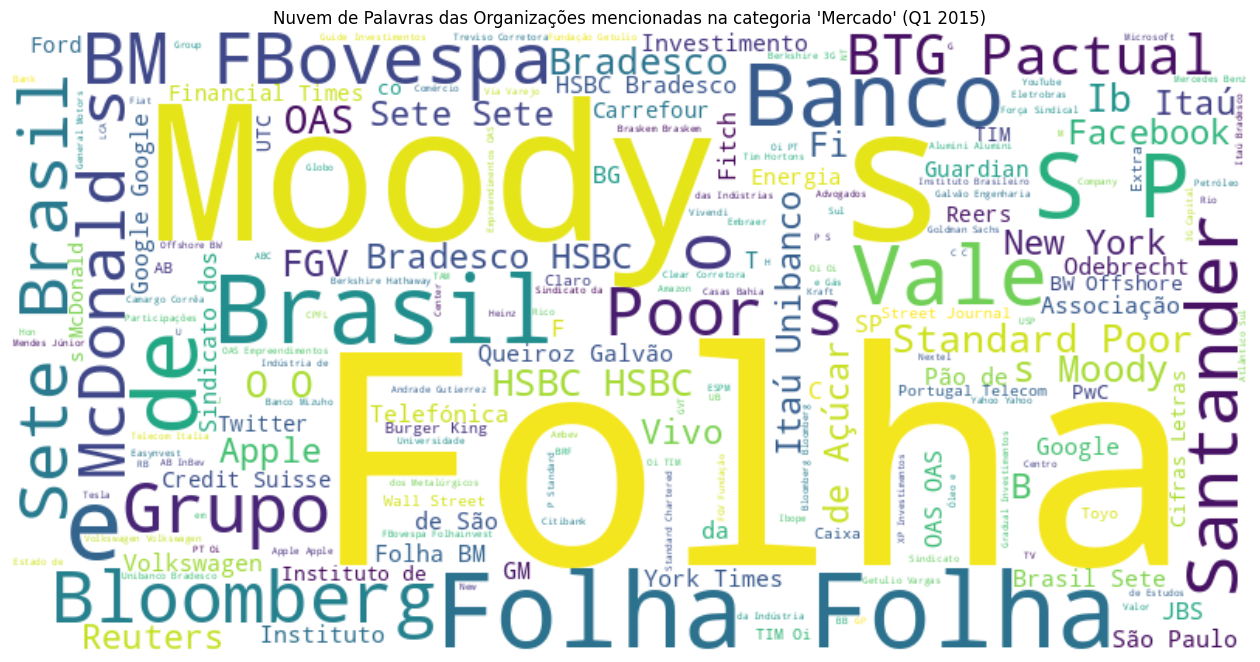

In [64]:
organization_string = " ".join(all_organizations)

def plot_wordcloud(text, ax):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    return ax

fig, ax = plt.subplots(figsize=(16, 12))
plot_wordcloud(organization_string, ax)
ax.set_title("Nuvem de Palavras das Organizações mencionadas na categoria 'Mercado' (Q1 2015)")
plt.show()